Import Games of Elo ~1100

In [134]:
import pandas as pd 
import torch 
from torch.utils.data import Dataset
import dask.dataframe as dd 
import numpy as np
import torch.nn as nn
import math
import chess
import random
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [111]:
# Import CSV File (from Maia: http://csslab.cs.toronto.edu/datasets/#monthly_chess_csv)
# The CSV has 151,072,060 rows
data_types ={'clock': 'float32',
       'cp': 'object',
       'opp_clock': 'float32',
       'opp_clock_percent': 'float32'}
df = dd.read_csv('../data/lichess_db_standard_rated_2019-01.csv', blocksize='64e6', dtype= data_types, low_memory=False)

# Filter out quick games (Bullet and HyperBullet) and take out moves that happened in the last XX seconds (this won't affect how many games we import but the # of moves we look at)
condition_time_control = ~df['time_control'].isin(['Bullet', 'HyperBullet'])
condition_clock = df['clock'] > 45
# condition_plays = df['num_ply'] < 80
filtered_df = df[condition_time_control & condition_clock]

# Select Relevant Columns
selected_columns = ['game_id','white_elo','black_elo','move','white_active','board']
filtered_df = filtered_df[selected_columns]

# Filter only games of Elo 1100-1199
filtered_df = filtered_df[(filtered_df['white_elo'].between(1100, 1199)) & (filtered_df['black_elo'].between(1100, 1199))]

# Group Same Games Together 
def aggregate_moves(group):
    moves = ' '.join(group['move'])  # Concatenate moves into a single string
    white_elo = group['white_elo'].iloc[0]  # Get the first white_elo
    black_elo = group['black_elo'].iloc[0]  # Get the first black_elo
    white_active = group['white_active'].iloc[0]  # Get the first num_ply
    board = '*'.join(group['board'])  # Get the first num_ply
    return pd.Series({'moves': moves, 'white_elo': white_elo, 'black_elo': black_elo, 'white_active': white_active, 'board': board})

grouped_df = filtered_df.groupby('game_id',sort=True).apply(aggregate_moves, meta={'moves': 'str', 'white_elo': 'int', 'black_elo': 'int', 'white_active': 'str', 'board': 'str'}).compute()

# This gives us 99,300 Games when we don't filter games with more than 80 half-moves
print(grouped_df)


In [139]:
print(filtered_df)

         game_id  white_elo  black_elo  move  white_active  \
1223    MpE9bxRV       1180       1125  e2e4          True   
1224    MpE9bxRV       1180       1125  e7e5         False   
1225    MpE9bxRV       1180       1125  g1f3          True   
1226    MpE9bxRV       1180       1125  f7f6         False   
1227    MpE9bxRV       1180       1125  f1b5          True   
...          ...        ...        ...   ...           ...   
226499  L7OPs0AX       1160       1166  d7c8         False   
226500  L7OPs0AX       1160       1166  e4e5          True   
226501  L7OPs0AX       1160       1166  d6c5         False   
226502  L7OPs0AX       1160       1166  h5f5          True   
226504  L7OPs0AX       1160       1166  c3e4          True   

                                                    board  
1223    rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...  
1224    rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...  
1225    rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...  
1226    rnbqkbn

In [135]:
grouped_df.to_csv('haha_longer.csv')

In [140]:
print(grouped_df)

                                                      moves  white_elo  \
game_id                                                                  
001QYJhZ  d2d4 f7f6 c2c4 e7e5 d4e5 f6e5 e2e3 b8c6 b1c3 f...       1127   
0073Uoft  e2e4 e7e5 g1f3 b8c6 f1c4 g8f6 f3g5 d7d5 g5f7 e...       1142   
008AlITg  e2e4 e7e5 g1f3 b8c6 b1c3 g8f6 f3e5 f8b4 e5c6 d...       1187   
00911g2y  e2e4 d7d5 e4d5 d8d5 g1f3 d5a5 b1c3 g8f6 d2d4 c...       1135   
00A6eGbe  b2b4 e7e5 c1b2 g8f6 b2e5 b8c6 e5c3 d7d5 d2d4 f...       1112   
...                                                     ...        ...   
zzo2DSPt  d2d4 g8f6 c1f4 g7g6 g1f3 f8g7 b1c3 e8g8 e2e3 d...       1141   
zzo5kmuO  e2e4 e7e5 g1f3 d7d6 b1c3 c8g4 f1e2 g4f3 e2f3 d...       1112   
zztPJDK8  e2e4 c7c5 g1f3 b8c6 f1c4 e7e6 d2d3 d7d5 e4d5 e...       1178   
zzx4qVJx  e2e3 d7d5 f2f4 g8f6 b2b3 e7e6 c1b2 f6e4 g2g4 d...       1197   
zzxkXY9h  d2d4 d7d5 g1f3 g8f6 c1f4 b8c6 e2e3 c8f5 f1b5 f...       1140   

          black_elo  white_active  \


In [141]:
# Line by line reading the data -> there are some broken lines
for move,board in (zip(grouped_df['moves'][20:22],grouped_df['board'][20:22])):
    for a,b in zip(move.split(' '),board.split('*')):
        print(a)
        print(b)
    print("new game")

e2e4
rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1
e7e6
rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1
g1f3
rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2
f7f6
rnbqkbnr/pppp1ppp/4p3/8/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 1 2
d2d4
rnbqkbnr/pppp2pp/4pp2/8/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 0 3
f8d6
rnbqkbnr/pppp2pp/4pp2/8/3PP3/5N2/PPP2PPP/RNBQKB1R b KQkq - 0 3
c2c4
rnbqk1nr/pppp2pp/3bpp2/8/3PP3/5N2/PPP2PPP/RNBQKB1R w KQkq - 1 4
c7c6
rnbqk1nr/pppp2pp/3bpp2/8/2PPP3/5N2/PP3PPP/RNBQKB1R b KQkq - 0 4
h2h3
rnbqk1nr/pp1p2pp/2pbpp2/8/2PPP3/5N2/PP3PPP/RNBQKB1R w KQkq - 0 5
b7b6
rnbqk1nr/pp1p2pp/2pbpp2/8/2PPP3/5N1P/PP3PP1/RNBQKB1R b KQkq - 0 5
b1c3
rnbqk1nr/p2p2pp/1ppbpp2/8/2PPP3/5N1P/PP3PP1/RNBQKB1R w KQkq - 0 6
c8a6
rnbqk1nr/p2p2pp/1ppbpp2/8/2PPP3/2N2N1P/PP3PP1/R1BQKB1R b KQkq - 1 6
b2b3
rn1qk1nr/p2p2pp/bppbpp2/8/2PPP3/2N2N1P/PP3PP1/R1BQKB1R w KQkq - 2 7
c6c5
rn1qk1nr/p2p2pp/bppbpp2/8/2PPP3/1PN2N1P/P4PP1/R1BQKB1R b KQkq - 0 7
d4d5
rn1qk1nr/p2p2pp/bp1bpp2/2p5/2P

Now that we have our raw data, we need to be able to make sense of chess moves. Meaning, we're transforming our entire world from chess moves into numerical tokens that will serve as indices into unique embeddings

In [144]:
# First, generate a mapping from each move to a unique embedding. In order to index into our matrix of 
# embeddings (matrix format so it's something we can tune), we'll also want a mapping from each move to a unique ID
class Vocabulary:
    def __init__(self):
        self.move_to_id = {"<UNK>": 0}
        self.id_to_move = {0: "<UNK>"}
        self.index = 1  # Start indexing from 1

    def add_move(self, move):
        if move not in self.move_to_id:
            self.move_to_id[move] = self.index
            self.id_to_move[self.index] = move
            self.index += 1

    def get_id(self, move):
        return self.move_to_id.get(move, self.move_to_id["<UNK>"])

    def get_move(self, id):
        return self.id_to_move.get(id, self.id_to_move[0])

# We can just use nn.Embedding later when we pass the model a sequence of indices, but this is if we ever want to pre-train and have access to the matrix we've trained
def get_embedding_matrix(vocab, d_embed):
    n_embed = len(vocab.move_to_id)
    return np.random.normal(0, 1, (n_embed, d_embed))
# embedding_matrix = get_embedding_matrix(vocab, 64)
    
# Now let's turn our data into sequences of indices, encoding the moves into a vocabulary

def df_to_data(df, fixed_window=False, fixed_window_size=32, sampling_rate=1, algebraic_notation=True):
    """
    Input: Dataframe of training data in which each row represents a full game played between players
    Output: List in which each item represents some game's history up until a particular move, List in the same order in which the associated label is the following move
    """
    subsequences = []
    next_moves = []
    vocab = Vocabulary()
    board = chess.Board()
    for game in df['moves']:
        moves = game.split()
        # Turn the game into a list of moves
        encoded_moves = []
        for move in moves:
            # Create a move object from the coordinate notation
            move_obj = chess.Move.from_uci(move)
            if move_obj not in board.legal_moves:
                break 
            else:
                if algebraic_notation:
                    algebraic_move = board.san(move_obj)
                    board.push(move_obj)
                    vocab.add_move(algebraic_move)
                    encoded_move = vocab.get_id(algebraic_move)
                    encoded_moves.append(encoded_move)
                else:
                    encoded_move = vocab.get_id(move)
                    encoded_moves.append(encoded_move)
        board.reset()
        # Turn the list of moves into subsequences
        for i in range(len(encoded_moves)-1):
            if random.uniform(0, 1) <= sampling_rate:
                subseq = encoded_moves[0:i+1]
                if fixed_window and len(subseq) > fixed_window_size:
                    subseq = subseq[-fixed_window_size:]
                label = encoded_moves[i+1]
                subsequences.append(subseq)
                next_moves.append(label)

    return subsequences, next_moves, vocab

# Function to pad move sequences & get their sequence lengths
def pad_sequences(sequences, max_len=None, pad_id=0):
    if max_len is None:
        max_len = max(len(seq) for seq in sequences)
    padded_sequences = np.full((len(sequences), max_len), pad_id, dtype=int)
    sequence_lengths = np.zeros(len(sequences), dtype=int)
    for i, seq in enumerate(sequences):
        length = len(seq)
        padded_sequences[i, :length] = seq[:length]
        sequence_lengths[i] = length
    return padded_sequences, sequence_lengths

class SequenceDataset(Dataset):
    def __init__(self, sequences, lengths, labels):
        self.sequences = sequences
        self.lengths = lengths
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.lengths[idx], self.labels[idx]
    

In [153]:
trainX, trainY, vocab = df_to_data(grouped_df, fixed_window=True, sampling_rate=0.5)
trainX, trainX_seqlengths  = pad_sequences(trainX)

In [154]:
print(len(vocab.id_to_move.keys()))
print(len(trainX[140]))

5690
32


In [155]:
"""Note: The input to the Embedding module is a list of indices, and the output is the corresponding word embeddings."""
# Bi-LSTM Model for PyTorch
class RNNModel(nn.Module):
    def __init__(self, vocab, d_embed, d_hidden, d_out, dropout = 0.5, num_layers = 2, bidirectional = False, embedding_matrix = None):
        super(RNNModel, self).__init__()
        self.embeddings = nn.Embedding(len(vocab.move_to_id), d_embed)
        # self.embeddings = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.lstm = nn.LSTM(d_embed, d_hidden, dropout = dropout, bidirectional=bidirectional, num_layers = num_layers)
        self.fc = nn.Sequential(
            nn.Linear(d_hidden,d_out)
        )

    def forward(self, x, seq_lengths):
        x = self.embeddings(x)
        # Sort x and seq_lengths in descending order
        # This is required for packing the sequence
        seq_lengths, perm_idx = seq_lengths.sort(0, descending=True)
        x = x[perm_idx]
        # Pack the sequence
        packed_input = pack_padded_sequence(x, seq_lengths, batch_first=True)
        # Pass the packed sequence through the LSTM
        packed_output, (hidden, cell) = self.lstm(packed_input)

        # Unpack the sequence
        output, _ = pad_packed_sequence(packed_output, batch_first=True,total_length = x.size()[1])
        _, unperm_idx = perm_idx.sort(0)
        #unperm_idx = unperm_idx.to(self.device)
        output = output.index_select(0, unperm_idx)
        #This takes all the outputs across the cells
        mean_pooled = torch.mean(output, dim=1)
        #output = torch.cat((mean_pooled,hidden[-1]),dim=1)
        output = self.fc(mean_pooled)
        return output

In [148]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel

Functions for training

In [169]:
# Function to calculate top-3 accuracy
def top_3_accuracy(y_true, y_pred):
    top3 = torch.topk(y_pred, 3, dim=1).indices
    correct = top3.eq(y_true.view(-1, 1).expand_as(top3))
    return correct.any(dim=1).float().mean().item()

def train_rnn(device, model, train_loader, val_loader, criterion, optimizer, num_epochs, learn_decay):
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    val_3_accuracy = []
    swa_model = AveragedModel(model)
    swa_start = 1
    for epoch in range(num_epochs):
        train_correct = 0
        train_total = 0
        training_loss = 0.0
        # Training
        model.train()
        count = 0
        for sequences, lengths, labels in train_loader:
            count += 1
            sequences, lengths, labels = sequences.to(device), lengths.to(device), labels.to(device)
            # Forward Pass
            output = model(sequences, lengths)
            loss = criterion(output, labels)
            # Backpropogate & Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # For logging purposes
            training_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            if count % 1000 == 0:
                print(f'Epoch {epoch+1}, Batch: {count}| Training Loss: {training_loss/count}')
        if epoch >= swa_start:
            swa_model.update_parameters(model)
        torch.optim.swa_utils.update_bn(train_loader, swa_model)
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        validation_loss = 0.0
        if val_loader is not None:
            with torch.no_grad():
                val_correct = 0
                val_total = 0
                val_top3_correct = 0
                validation_loss = 0

                for sequences, lengths, labels in val_loader:
                    sequences, lengths, labels = sequences.to(device), lengths.to(device), labels.to(device)
                    outputs = model(sequences, lengths)
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    val_top3_correct += top_3_accuracy(labels, outputs) * labels.size(0)
                    loss = criterion(outputs, labels)
                    validation_loss += loss.item()

                val_loss_values.append(validation_loss / len(val_loader))
                val_accuracy = 100 * val_correct / val_total
                val_top3_accuracy = 100 * val_top3_correct / val_total
                val_error.append(100 - val_accuracy)
                val_3_accuracy.append(val_top3_accuracy)

        # Log Model Performance  
        train_loss_values.append(training_loss)
        train_error.append(100-100*train_correct/train_total)
        print(f'Epoch {epoch+1}, Training Loss: {training_loss/len(train_loader)}, Validation Error: {val_error[-1]}, Validation Top-3 Accuracy: {val_3_accuracy[-1]}, Training Error: {train_error[-1]}')
        for op_params in optimizer.param_groups:
            op_params['lr'] = op_params['lr'] * learn_decay
    return train_error,train_loss_values, val_error, val_loss_values, swa_model

Now let's train

In [157]:
dataset = SequenceDataset(trainX, trainX_seqlengths, trainY)
# Calculate split sizes
total_size = len(dataset)
print(total_size)

2269072


# Experiments

## Experiment 1 (with UCI Notation)

In [162]:
# We're scaling the model size so let's bring in more data as well
train_size = int(0.95 * total_size)
val_size = int(total_size * 0.04)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)

# Reload the data with particular batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
d_hidden = 128
d_embed = 128
NUM_EPOCHS = 10
d_out = len(vocab.id_to_move.keys())
model = RNNModel(vocab,d_embed,d_hidden,d_out,num_layers=2) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 2e-3
weight_decay=0
learn_decay = 0.5
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

2155618
1726522


In [ ]:

# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_rnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('validation_error_model_rnn.png')  # This will save the plot as an image

Achieved up to 9% Accuracy and 15% Top-3 Accuracy

## Experiment 2 (With SAN Notation)

In [170]:
# We're scaling the model size so let's bring in more data as well
train_size = int(0.95 * total_size)
val_size = int(total_size * 0.04)

# Create subsets for training and validation
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
print(train_size)

2155618


In [171]:
# Reload the data with particular batch size
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
d_hidden = 128
d_embed = 64
NUM_EPOCHS = 4
d_out = len(vocab.id_to_move.keys())
model = RNNModel(vocab,d_embed,d_hidden,d_out,num_layers=2) 
model = model.to(device)
criterion = nn.CrossEntropyLoss()
lr = 1e-3
weight_decay=1e-7
learn_decay = 0.7 # This causes the LR to be 2e-5 by epoch 10
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1329594


Epoch 1, Batch: 1000| Training Loss: 6.54264478302002
Epoch 1, Batch: 2000| Training Loss: 6.331903526544571
Epoch 1, Batch: 3000| Training Loss: 6.227019751866658
Epoch 1, Batch: 4000| Training Loss: 6.159396840929985
Epoch 1, Batch: 5000| Training Loss: 6.110649178314209
Epoch 1, Batch: 6000| Training Loss: 6.070694284598033
Epoch 1, Batch: 7000| Training Loss: 6.038508758136205
Epoch 1, Batch: 8000| Training Loss: 6.012047487616539
Epoch 1, Batch: 9000| Training Loss: 5.989427676942613
Epoch 1, Batch: 10000| Training Loss: 5.967862135267258
Epoch 1, Batch: 11000| Training Loss: 5.9481815090612935
Epoch 1, Batch: 12000| Training Loss: 5.931767913341522
Epoch 1, Batch: 13000| Training Loss: 5.915213303235861
Epoch 1, Batch: 14000| Training Loss: 5.899652664014272
Epoch 1, Batch: 15000| Training Loss: 5.884520425128937
Epoch 1, Batch: 16000| Training Loss: 5.8707751305699345
Epoch 1, Batch: 17000| Training Loss: 5.857078111143673
Epoch 1, Batch: 18000| Training Loss: 5.84480541952451
E

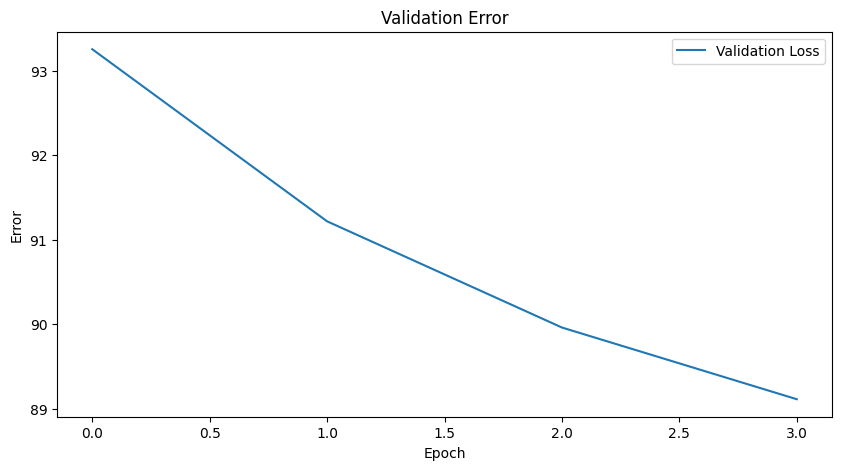

<Figure size 640x480 with 0 Axes>

In [172]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_rnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('validation_error_model_rnn.png')  # This will save the plot as an image

Epoch 1, Batch: 1000| Training Loss: 4.969356063127518
Epoch 1, Batch: 2000| Training Loss: 4.968740664601326
Epoch 1, Batch: 3000| Training Loss: 4.97100979590416
Epoch 1, Batch: 4000| Training Loss: 4.973653480052948
Epoch 1, Batch: 5000| Training Loss: 4.972886877393723
Epoch 1, Batch: 6000| Training Loss: 4.970418695052465
Epoch 1, Batch: 7000| Training Loss: 4.968450478179114
Epoch 1, Batch: 8000| Training Loss: 4.968681950390339
Epoch 1, Batch: 9000| Training Loss: 4.966966407934825
Epoch 1, Batch: 10000| Training Loss: 4.964161391401291
Epoch 1, Batch: 11000| Training Loss: 4.962620267282833
Epoch 1, Batch: 12000| Training Loss: 4.9635553870201115
Epoch 1, Batch: 13000| Training Loss: 4.962886018698032
Epoch 1, Batch: 14000| Training Loss: 4.961386224814824
Epoch 1, Batch: 15000| Training Loss: 4.959618728351593
Epoch 1, Batch: 16000| Training Loss: 4.95848834875226
Epoch 1, Batch: 17000| Training Loss: 4.956844354559394
Epoch 1, Batch: 18000| Training Loss: 4.956113832632701
Ep

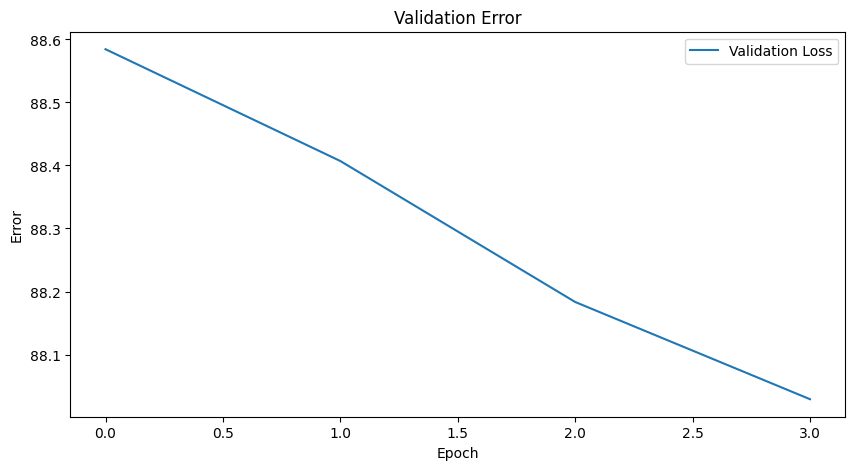

<Figure size 640x480 with 0 Axes>

In [173]:
# Train the model
train_error,train_loss_values, val_error, val_loss_value,swa_model = train_rnn(device, model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, learn_decay)

# Plot the training error
plt.figure(figsize=(10, 5))
plt.plot(val_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Error')
plt.legend()
plt.show()
plt.savefig('validation_error_model_rnn.png')  # This will save the plot as an image

What happens if we filter out illegal moves in our prediction?

In [211]:
def is_legal_move(chess_board, move_san):
    try:
        chess_move = chess_board.parse_san(move_san)
        return chess_move in chess_board.legal_moves
    except ValueError:
        # This handles cases where the SAN move cannot be parsed or is not legal
        return False

def load_board_state_from_san(moves):
    board = chess.Board()
    for index in moves:
        try:
            if index == 0:
                return board
            else:
                move_san = vocab.get_move(index.item())
                move = board.parse_san(move_san)
                board.push(move)
        except ValueError:
            # Handle invalid moves, e.g., break the loop or log an error
            break
    return board

val_size = int(total_size * 0.0001)
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

model.eval()
val_correct = 0
val_total = 0

if val_loader is not None:
    with torch.no_grad():
        for sequences, lengths, labels in val_loader:
            print("hey")
            sequences, lengths, labels = sequences.to(device), lengths.to(device), labels.to(device)
            outputs = model(sequences, lengths)
            probabilities = torch.softmax(outputs, dim=1)
            minus = 0
            for idx, (sequence, label) in enumerate(zip(sequences, labels)):
                if sequence[-1].item() == 0 and sequence[2].item() != 0 and sequence[3].item() != 0 and sequence[4].item() != 0:
                    output = probabilities[idx]
                    sorted_probs, sorted_indices = torch.sort(output, descending=True)
                    predicted_move = sorted_indices[0]
                    print(predicted_move)
                    chess_board = load_board_state_from_san(sequence)
                    for move_idx in sorted_indices:
                        move = vocab.get_move(move_idx.item()) # Convert index to move (e.g., 'e2e4')
                        if is_legal_move(chess_board, move):
                            print("we found one")
                            predicted_move = vocab.get_id(move)
                            break
                    
                    # Check if predicted move is correct
                    correct_move = label.item() # Convert label to move
                    print(correct_move)
                    if predicted_move == correct_move:
                        val_correct += 1
                else:
                    minus += 1
            val_total += (labels.size(0) - minus)

        val_accuracy = 100 * val_correct / val_total
        print(f"Validation Accuracy: {val_accuracy}%")


hey
tensor(17)
Nf6
we found one


TypeError: 'dict' object is not callable